<b>CSC 522 Automated Learning and Data Analysis</b><br>
Project Group: 14 : {agmalpur}, {rkulkar5}, {radange}<br>
Title: Customer Churn Prediction using Telco Customer Churn Dataset

In [ ]:
#importing all required libraries
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import random
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
import pickle

import os
import warnings
warnings.filterwarnings('ignore')

np.random.seed(2024)
random.seed(2024)

<h2> Understanding the Data

In [2]:
#Reading the Dataset from local source
df=pd.read_csv(r'D:\NCSU\Fall 2024\ALDA\Project\Telco_Customer_Churn_with_NaNs.csv')
#Splitting the data into train and test sets (70% train data and 30% test data)
train, test = train_test_split(df, test_size=0.3, random_state=2024)
test=test.drop('Churn', axis=1) #dropping the 'Churn' column in test data to predict the results

In [3]:
train.shape #checking the shape of the training data

(4930, 21)

In [4]:
train.head() #glancing at the training data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
4097,9974-JFBHQ,Male,0.0,No,Yes,64.0,Yes,No,Fiber optic,No,...,No,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),NaN,6171.2,No
1688,4735-BJKOU,Female,0.0,No,No,40.0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.15,804.85,No
6215,2446-BEGGB,Female,NaN,No,No,6.0,Yes,Yes,Fiber optic,No,...,No,No,Yes,NaN,Month-to-month,NaN,Electronic check,NaN,560.6,Yes
5828,0402-OAMEN,Female,0.0,Yes,Yes,72.0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),24.45,1709.1,No
5586,1998-VHJHK,Female,0.0,No,No,27.0,Yes,NaN,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,NaN,19.15,501.35,No


In [5]:
train.info() #getting insights upon the training data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4930 entries, 4097 to 3578
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        4930 non-null   object 
 1   gender            4691 non-null   object 
 2   SeniorCitizen     4701 non-null   float64
 3   Partner           4703 non-null   object 
 4   Dependents        4661 non-null   object 
 5   tenure            4700 non-null   float64
 6   PhoneService      4679 non-null   object 
 7   MultipleLines     4695 non-null   object 
 8   InternetService   4683 non-null   object 
 9   OnlineSecurity    4698 non-null   object 
 10  OnlineBackup      4651 non-null   object 
 11  DeviceProtection  4660 non-null   object 
 12  TechSupport       4668 non-null   object 
 13  StreamingTV       4702 non-null   object 
 14  StreamingMovies   4669 non-null   object 
 15  Contract          4677 non-null   object 
 16  PaperlessBilling  4691 non-null   objec

In [6]:
#getting the overall statistics for the training data 
train.describe(include='all').transpose()
#describe by default will only give values of numerical attributes, 'inlcude all' will also include categorical features.

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,4930,4930,8190-ZTQFB,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,4691,2,Male,2369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,4701.0,NaN,NaN,NaN,0.160817,0.367401,0.0,0.0,0.0,0.0,1.0
Partner,4703,2,No,2424,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,4661,2,No,3272,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,4700.0,NaN,NaN,NaN,32.364043,24.453534,0.0,9.0,29.0,55.0,72.0
PhoneService,4679,2,Yes,4238,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,4695,3,No,2254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,4683,3,Fiber optic,2084,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,4698,3,No,2350,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
test.shape #getting the shape of the test dataset 

(2113, 20)

In [8]:
test.head() #glancing over the test data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
825,2311-QYMUQ,Female,0.0,Yes,Yes,16.0,Yes,No,Fiber optic,No,NaN,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.45,1430.25
6768,9739-JLPQJ,Female,0.0,Yes,Yes,72.0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),117.50,8670.1
2274,0320-JDNQG,Male,0.0,Yes,NaN,23.0,Yes,No,Fiber optic,Yes,No,No,Yes,NaN,Yes,Month-to-month,Yes,Electronic check,99.85,2331.3
2580,7748-UMTRK,Female,1.0,No,Yes,30.0,Yes,Yes,Fiber optic,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,101.30,2974.5
4206,0017-IUDMW,Female,0.0,Yes,Yes,NaN,NaN,NaN,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),116.80,8456.75


In [9]:
test.info() #getting to learn about the test data by getting its information

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2113 entries, 825 to 6375
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2113 non-null   object 
 1   gender            2021 non-null   object 
 2   SeniorCitizen     2018 non-null   float64
 3   Partner           1984 non-null   object 
 4   Dependents        2010 non-null   object 
 5   tenure            2009 non-null   float64
 6   PhoneService      2011 non-null   object 
 7   MultipleLines     2002 non-null   object 
 8   InternetService   2020 non-null   object 
 9   OnlineSecurity    1998 non-null   object 
 10  OnlineBackup      1997 non-null   object 
 11  DeviceProtection  1998 non-null   object 
 12  TechSupport       1996 non-null   object 
 13  StreamingTV       1995 non-null   object 
 14  StreamingMovies   2014 non-null   object 
 15  Contract          2014 non-null   object 
 16  PaperlessBilling  2005 non-null   object

In [10]:
test.describe(include='all').transpose() #looking at the statistics of the test data

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,2113,2113,0488-GSLFR,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,2021,2,Male,1023,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,2018.0,NaN,NaN,NaN,0.16551,0.371733,0.0,0.0,0.0,0.0,1.0
Partner,1984,2,No,1028,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,2010,2,No,1402,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,2009.0,NaN,NaN,NaN,32.870582,24.82886,0.0,9.0,29.0,57.0,72.0
PhoneService,2011,2,Yes,1805,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,2002,3,No,962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,2020,3,Fiber optic,873,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,1998,3,No,974,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#Checking for duplicates in the train dataset
train.duplicated().sum()

0

In [12]:
#Checking for duplicates in the test dataset
test.duplicated().sum()

0

In [13]:
#Finding the missing values in the train dataset
train.isna().sum()

customerID            0
gender              239
SeniorCitizen       229
Partner             227
Dependents          269
tenure              230
PhoneService        251
MultipleLines       235
InternetService     247
OnlineSecurity      232
OnlineBackup        279
DeviceProtection    270
TechSupport         262
StreamingTV         228
StreamingMovies     261
Contract            253
PaperlessBilling    239
PaymentMethod       240
MonthlyCharges      245
TotalCharges        236
Churn                 0
dtype: int64

In [14]:
#Finding the missing values in the test dataset
test.isna().sum()

customerID            0
gender               92
SeniorCitizen        95
Partner             129
Dependents          103
tenure              104
PhoneService        102
MultipleLines       111
InternetService      93
OnlineSecurity      115
OnlineBackup        116
DeviceProtection    115
TechSupport         117
StreamingTV         118
StreamingMovies      99
Contract             99
PaperlessBilling    108
PaymentMethod       116
MonthlyCharges      106
TotalCharges        105
dtype: int64

In [15]:
#Splitting the features upon the target variable output and getting the count (training data)
print('OnlineSecurity: ')
print(train['OnlineSecurity'].value_counts())
print('\n Gender: ')
print(train['gender'].value_counts())
print('\n Senior Citizen: ')
print(train['SeniorCitizen'].value_counts())
print('\n Partner: ')
print(train['Partner'].value_counts())
print('\n Payment Method: ')
print(train['PaymentMethod'].value_counts())
print('\n Contract: ')
print(train['Contract'].value_counts())
print('\n Streaming Movies: ')
print(train['StreamingMovies'].value_counts())
print('\n Tech Support:')
print(train['TechSupport'].value_counts())
print('\n Paperless Billing: ')
print(train['PaperlessBilling'].value_counts())
print('\n Streamming TV: ')
print(train['StreamingTV'].value_counts())
print('\n Device Protection: ')
print(train['DeviceProtection'].value_counts())
print('\n Churn: ')
print(train['Churn'].value_counts())

OnlineSecurity: 
No                     2350
Yes                    1359
No internet service     989
Name: OnlineSecurity, dtype: int64

 Gender: 
Male      2369
Female    2322
Name: gender, dtype: int64

 Senior Citizen: 
0.0    3945
1.0     756
Name: SeniorCitizen, dtype: int64

 Partner: 
No     2424
Yes    2279
Name: Partner, dtype: int64

 Payment Method: 
Electronic check             1600
Mailed check                 1077
Bank transfer (automatic)    1021
Credit card (automatic)       992
Name: PaymentMethod, dtype: int64

 Contract: 
Month-to-month    2574
Two year          1103
One year          1000
Name: Contract, dtype: int64

 Streaming Movies: 
No                     1853
Yes                    1837
No internet service     979
Name: StreamingMovies, dtype: int64

 Tech Support:
No                     2314
Yes                    1378
No internet service     976
Name: TechSupport, dtype: int64

 Paperless Billing: 
Yes    2799
No     1892
Name: PaperlessBilling, dtype: int64

In [16]:
#Splitting the features upon the target variable output and getting the count (test data)
print('OnlineSecurity: ')
print(test['OnlineSecurity'].value_counts())
print('\n Gender: ')
print(test['gender'].value_counts())
print('\n Senior Citizen: ')
print(test['SeniorCitizen'].value_counts())
print('\n Partner: ')
print(test['Partner'].value_counts())
print('\n Payment Method: ')
print(test['PaymentMethod'].value_counts())
print('\n Contract: ')
print(test['Contract'].value_counts())
print('\n Streaming Movies: ')
print(test['StreamingMovies'].value_counts())
print('\n Tech Support:')
print(test['TechSupport'].value_counts())
print('\n Paperless Billing: ')
print(test['PaperlessBilling'].value_counts())
print('\n Streamming TV: ')
print(test['StreamingTV'].value_counts())
print('\n Device Protection: ')
print(test['DeviceProtection'].value_counts())

OnlineSecurity: 
No                     974
Yes                    556
No internet service    468
Name: OnlineSecurity, dtype: int64

 Gender: 
Male      1023
Female     998
Name: gender, dtype: int64

 Senior Citizen: 
0.0    1684
1.0     334
Name: SeniorCitizen, dtype: int64

 Partner: 
No     1028
Yes     956
Name: Partner, dtype: int64

 Payment Method: 
Electronic check             649
Mailed check                 453
Bank transfer (automatic)    448
Credit card (automatic)      447
Name: PaymentMethod, dtype: int64

 Contract: 
Month-to-month    1100
Two year           510
One year           404
Name: Contract, dtype: int64

 Streaming Movies: 
No                     781
Yes                    758
No internet service    475
Name: StreamingMovies, dtype: int64

 Tech Support:
No                     976
Yes                    557
No internet service    463
Name: TechSupport, dtype: int64

 Paperless Billing: 
Yes    1163
No      842
Name: PaperlessBilling, dtype: int64

 Streamming

In [17]:
#The number of categories in the target column (unique entries in the target column)
train['Churn'].unique()

array(['No', 'Yes'], dtype=object)

<h2> Data Visualization

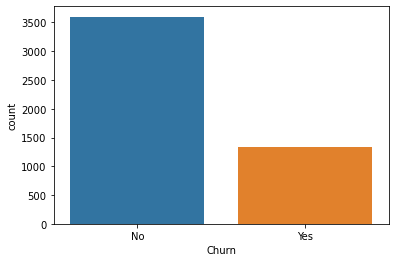

In [18]:
#The overall distribution of the categories in the Churn column in the training data visualized as a bar plot
sns.countplot(x='Churn', data=train)
plt.show()

In [19]:
#dropping the customerID feature since it is a nominal attribute and does not contribute to the understanding of whether a customer may churn or not.
train.drop(['customerID'], axis=1, inplace=True)
test.drop(['customerID'], axis=1, inplace=True)
#dropping the customerID feature in both train and test datasets
train['SeniorCitizen'] = train['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})
test['SeniorCitizen'] = test['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})

<function matplotlib.pyplot.show(close=None, block=None)>

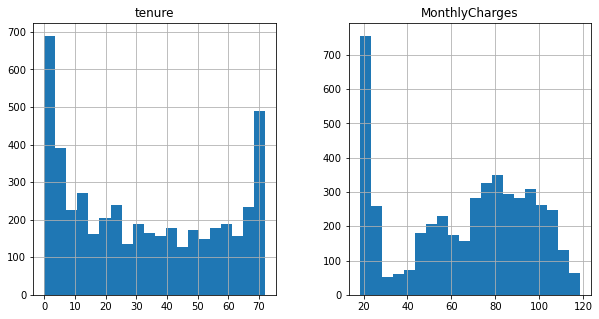

In [20]:
#plotting the histogram for numerical attributes to visualize the spread of values in it
train.hist(bins=20, figsize = (10,5))
plt.show
#TotalCharges is an object(ie. a categorical attribute) and therefore does not show up on one of these plots

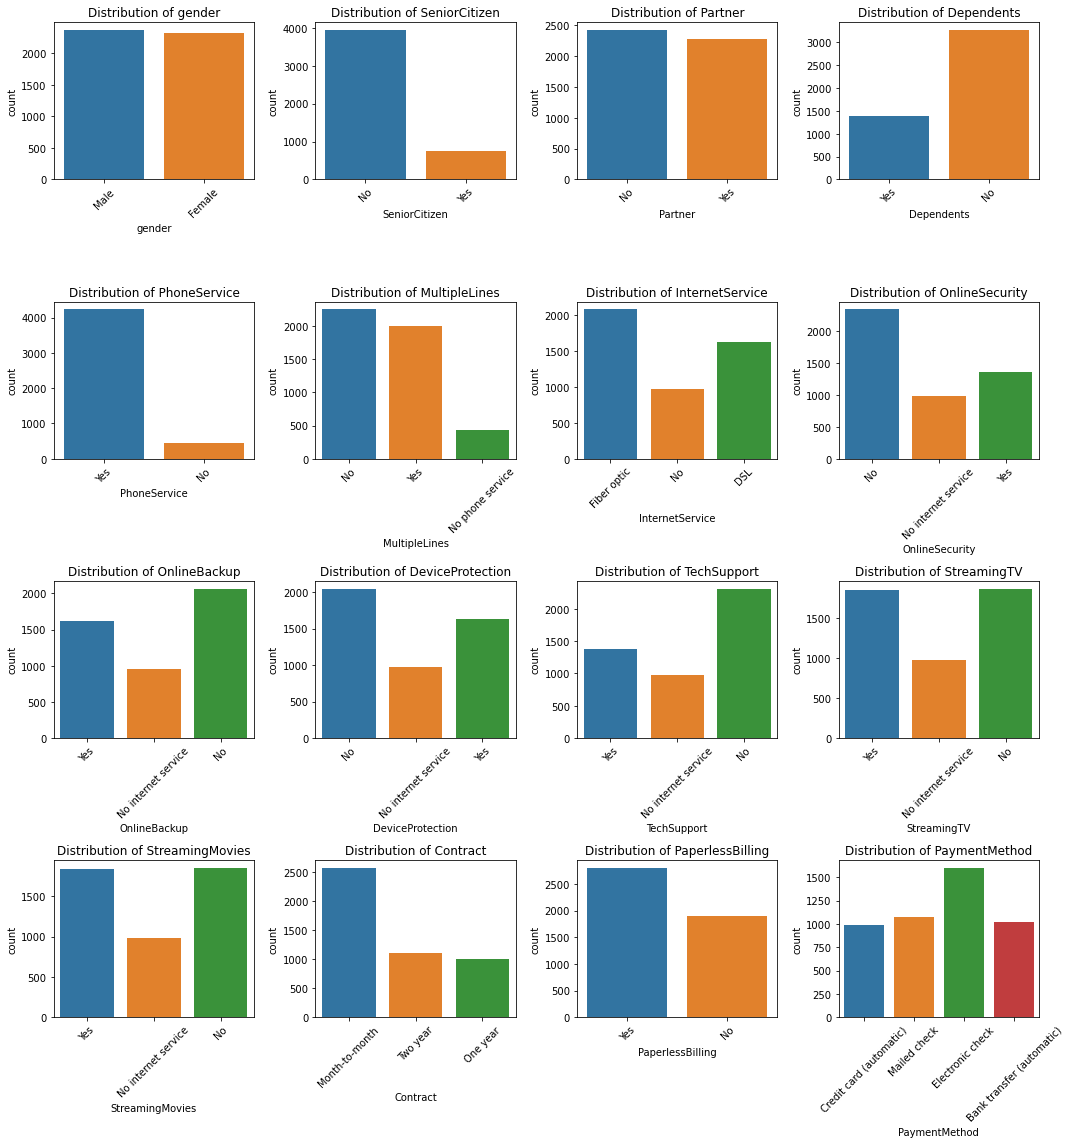

In [21]:
#plotting bar plots for all the categorical features in the dataset to visalize the overall spread of values in it

#categorical_columns stores all the categorical attributes in it, excluding attributes that have unique values in them (also the target variable)
categorical_columns = train.select_dtypes(include=['object', 'category']).columns
categorical_columns = categorical_columns.drop(['TotalCharges','Churn']) 
num_cols = 4  #We want 4 plots per row
num_rows = (len(categorical_columns) + num_cols - 1) // num_cols  #calculating the total rows required
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4)) #creating subplots
axes = axes.flatten() #flattening axes

# Plotting bar graphs for each categorical column in the dataset
for i, col in enumerate(categorical_columns):
    sns.countplot(data=train, x=col, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Removing empty subplots
for i in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

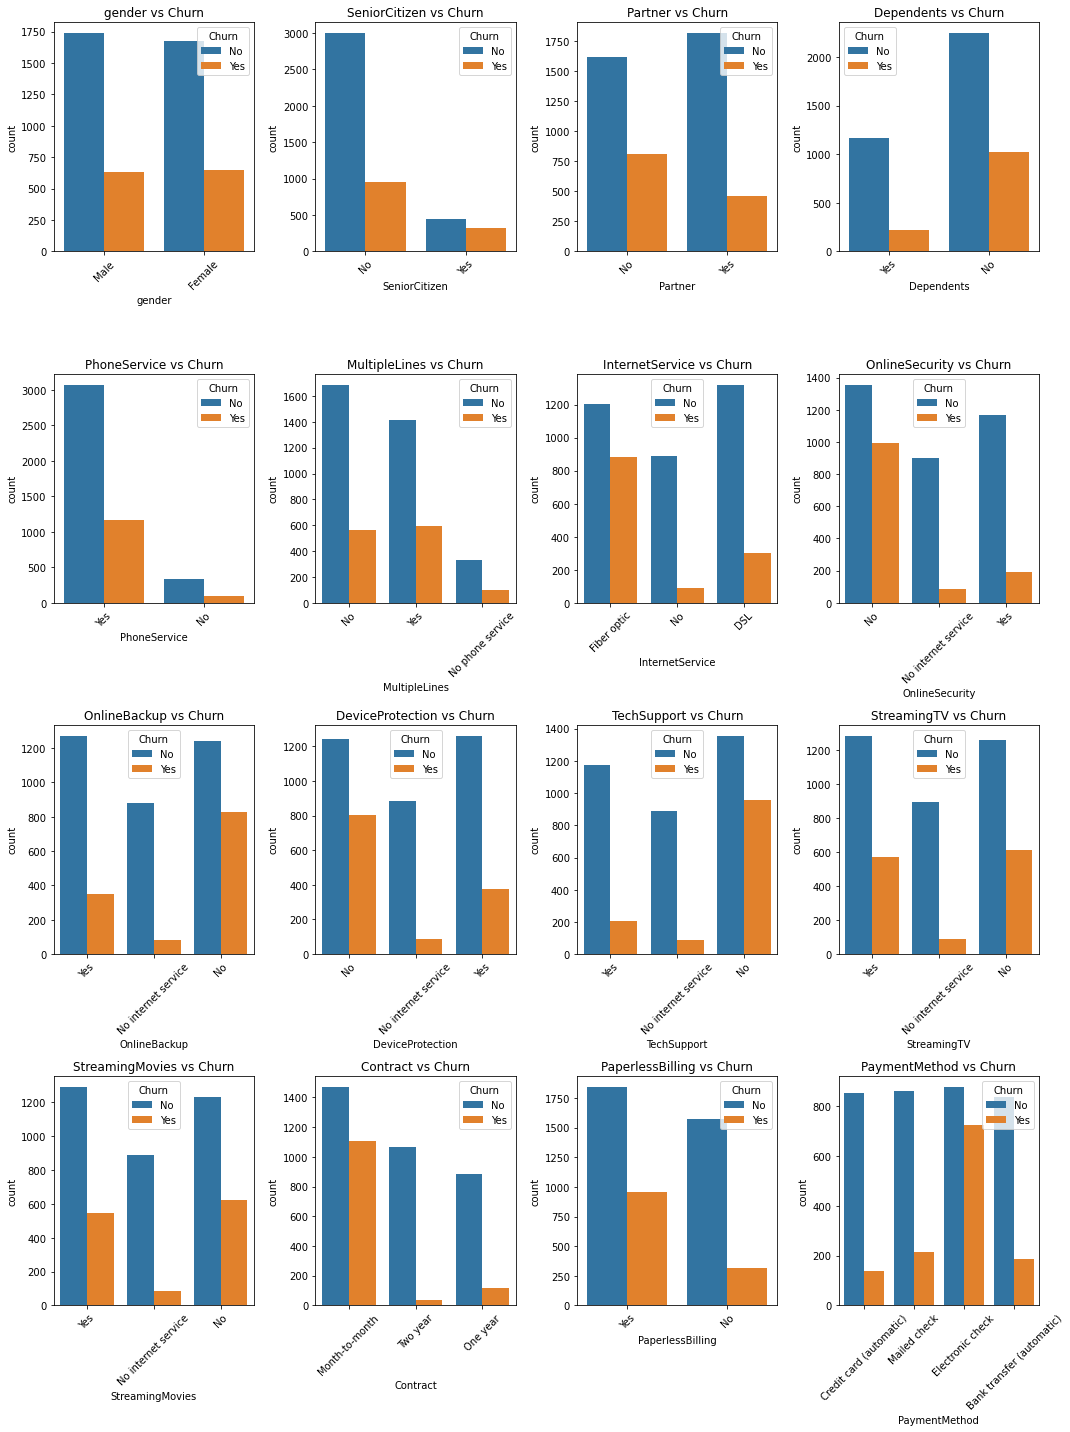

In [22]:
#Plotting bar graphs for the training dataset for attributes (to see the spread) according to the target variable Churn
num_cols = 4  #we require 4 plots per row
num_rows = (len(categorical_columns) + num_cols - 1) // num_cols  # Calculating the number of rows needed
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5)) # making subplots
axes = axes.flatten() #flattening axes

# Plot bar graphs for each categorical column with 'Churn' (depicted by the different hues)
for i, col in enumerate(categorical_columns):
    sns.countplot(data=train, x=col, hue='Churn', ax=axes[i])
    axes[i].set_title(f'{col} vs Churn')
    axes[i].tick_params(axis='x', rotation=45)
for i in range(len(categorical_columns), len(axes)): #removing the subplots
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

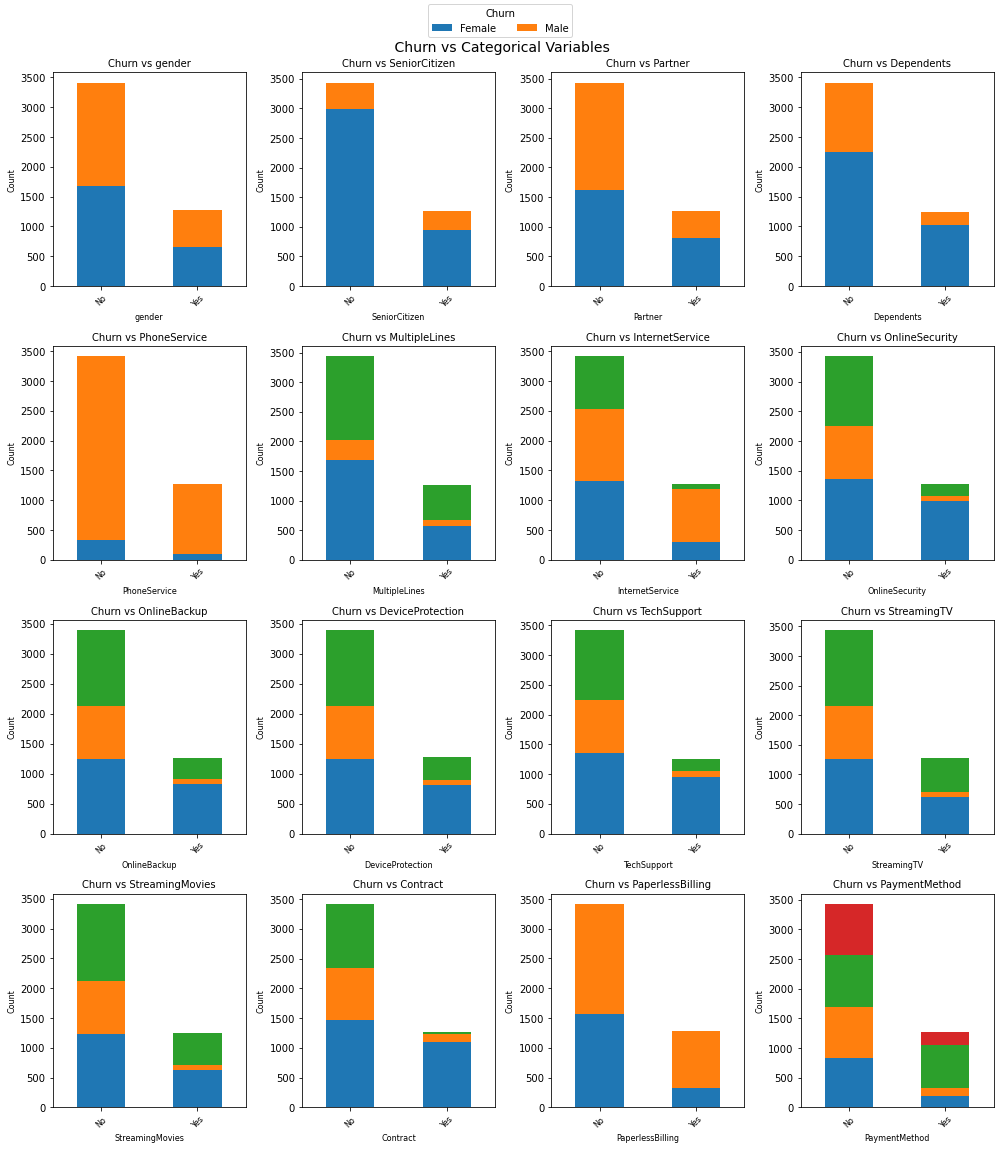

In [23]:
#Identifying the categorical columns (excluding 'Churn')
categorical_columns = train.select_dtypes(include=['object', 'category']).columns
#here we drop TotalCharges from the categorical ones since it is a numerical attribute and is currently treated as an object type. 
#We change it to float in the later part of the code
categorical_columns = categorical_columns.drop(['TotalCharges','Churn'])  # Exclude 'Churn'

#setting grid for visualizations
num_cols = 4
num_rows = (len(categorical_columns) + num_cols - 1) // num_cols  


fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, num_rows * 4)) 
axes = axes.flatten()  

# creating a stacked bar chart for all the categorical columns
for i, col in enumerate(categorical_columns):
    cross_tab = pd.crosstab(train['Churn'], train[col])
    cross_tab.plot(kind='bar', stacked=True, ax=axes[i], legend=False)  
    axes[i].set_title(f'Churn vs {col}', fontsize=10)
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].set_ylabel('Count', fontsize=8)
    axes[i].tick_params(axis='x', labelrotation=45, labelsize=8) 

for j in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[j])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Churn', loc='upper center', ncol=2, fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle('\n Churn vs Categorical Variables', fontsize=14)
plt.show()


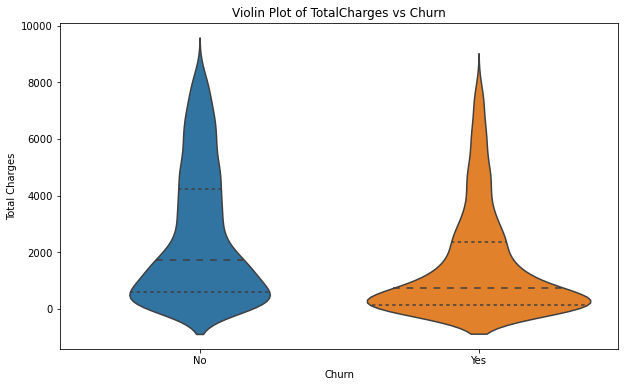

In [24]:
train['TotalCharges'] = pd.to_numeric(train['TotalCharges'], errors='coerce')

# Create the violin plot to better visualize the density trend of churn varying with total charges 
plt.figure(figsize=(10, 6))
sns.violinplot(x='Churn', y='TotalCharges', data=train, inner='quartile')
plt.title('Violin Plot of TotalCharges vs Churn')
plt.xlabel('Churn')
plt.ylabel('Total Charges')
plt.show()

<Figure size 720x432 with 0 Axes>

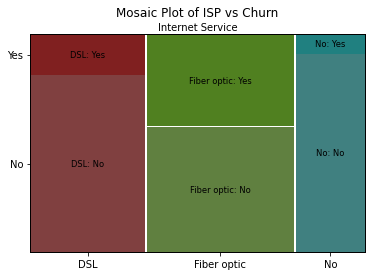

In [25]:
from statsmodels.graphics.mosaicplot import mosaic

# Creating a cross-tabulation of ISP and Churn
cross_tab = pd.crosstab(train['InternetService'], train['Churn'])

# Creating a mosaic plot for ISP vs Churn
plt.figure(figsize=(10, 6))
mosaic(cross_tab.stack(), title='Mosaic Plot of ISP vs Churn', labelizer=lambda k: f'{k[0]}: {k[1]}')
plt.xlabel('Internet Service')
plt.ylabel('Churn')
plt.show()

In [26]:
import plotly.graph_objects as go

# Create a DataFrame to hold the counts for the Sankey diagram
sankey_data = train.groupby(['InternetService', 'Contract', 'PaymentMethod', 'Churn']).size().reset_index(name='Count')

# Create labels for the Sankey diagram
labels = (list(sankey_data['InternetService'].unique()) + 
          list(sankey_data['Contract'].unique()) + 
          list(sankey_data['PaymentMethod'].unique()) + 
          list(sankey_data['Churn'].unique()))

# Create a mapping for the labels to indices
label_index = {label: idx for idx, label in enumerate(labels)}

# Create source, target, and value lists for the Sankey diagram
sources = []
targets = []
values = []

# Populate the sources, targets, and values
for _, row in sankey_data.iterrows():
    internet_service_index = label_index[row['InternetService']]
    contract_index = label_index[row['Contract']] + len(sankey_data['InternetService'].unique())
    payment_method_index = (label_index[row['PaymentMethod']] + 
                            len(sankey_data['InternetService'].unique()) + 
                            len(sankey_data['Contract'].unique()))
    churn_index = (label_index[row['Churn']] + 
                   len(sankey_data['InternetService'].unique()) + 
                   len(sankey_data['Contract'].unique()) + 
                   len(sankey_data['PaymentMethod'].unique()))
    
    # First layer: InternetService to Contract
    sources.append(internet_service_index)
    targets.append(contract_index)
    values.append(row['Count'])
    
    # Second layer: Contract to PaymentMethod
    sources.append(contract_index)
    targets.append(payment_method_index)
    values.append(row['Count'])
    
    # Third layer: PaymentMethod to Churn
    sources.append(payment_method_index)
    targets.append(churn_index)
    values.append(row['Count'])

# Define colors for different categories
node_colors = []
for label in labels:
    if label in sankey_data['InternetService'].unique():
        node_colors.append('lightblue')  # InternetService color
    elif label in sankey_data['Contract'].unique():
        node_colors.append('lightgreen')  # Contract color
    elif label in sankey_data['PaymentMethod'].unique():
        node_colors.append('lightcoral')  # PaymentMethod color
    else:
        node_colors.append('green')  # Churn color

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors  # Apply colors here
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    ))])

fig.update_layout(title_text="Sankey Diagram: Flow of Internet Service, Contract Type, Payment Method, and Customer Churn", font_size=10)
fig.show()

In [29]:

train['SeniorCitizen'] = train['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})
test['SeniorCitizen'] = test['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})
train['DeviceProtection'] = train['DeviceProtection'].replace({'No': 'No internet service'})
test['DeviceProtection'] = test['DeviceProtection'].replace({'No': 'No internet service'})
train['MultipleLines'] = train['MultipleLines'].replace({'No': 'No phone service'})
test['MultipleLines'] = test['MultipleLines'].replace({'No': 'No phone service'})
train['OnlineBackup'] = train['OnlineBackup'].replace({'No': 'No internet service'})
test['OnlineBackup'] = test['OnlineBackup'].replace({'No': 'No internet service'})

train['OnlineSecurity'] = train['OnlineSecurity'].replace({'No': 'No internet service'})
test['OnlineSecurity'] = test['OnlineSecurity'].replace({'No': 'No internet service'})
train['TechSupport'] = train['TechSupport'].replace({'No': 'No internet service'})
test['TechSupport'] = test['TechSupport'].replace({'No': 'No internet service'})
train['StreamingTV'] = train['StreamingTV'].replace({'No': 'No internet service'})
test['StreamingTV'] = test['StreamingTV'].replace({'No': 'No internet service'})
train['StreamingMovies'] = train['StreamingMovies'].replace({'No': 'No internet service'})
test['StreamingMovies'] = test['StreamingMovies'].replace({'No': 'No internet service'})


In [27]:
#Change the data type of the Total Charges column
train['TotalCharges'] = train['TotalCharges'].replace(' ', np.nan)
#Converting The total charges column into float
train["TotalCharges"]=train.TotalCharges.apply(lambda x:float(x))

In [28]:
#Change the data type of the Total charges column in the test data set
test['TotalCharges'] = test['TotalCharges'].replace(' ', np.nan)
#COnvert The total charges column into float
test["TotalCharges"]=test.TotalCharges.apply(lambda x:float(x))

In [29]:
#The percentage of the missing values
(train.isna().sum()*100)/ len(train)

gender              4.847870
SeniorCitizen       4.645030
Partner             4.604462
Dependents          5.456389
tenure              4.665314
PhoneService        5.091278
MultipleLines       4.766734
InternetService     5.010142
OnlineSecurity      4.705882
OnlineBackup        5.659229
DeviceProtection    5.476673
TechSupport         5.314402
StreamingTV         4.624746
StreamingMovies     5.294118
Contract            5.131846
PaperlessBilling    4.847870
PaymentMethod       4.868154
MonthlyCharges      4.969574
TotalCharges        4.908722
Churn               0.000000
dtype: float64

## Imputing the Missing Values

In [30]:
#Imputing the numerical columns using mean
numerical_imputer = SimpleImputer(strategy='mean')

In [31]:
#Numerical Columns
numerical_columns = ['tenure', 'TotalCharges','MonthlyCharges']


In [32]:
#Imputing the numerical columns in the train dataset using fit transform
for column in numerical_columns:
    train[column] = numerical_imputer.fit_transform(train[column].values.reshape(-1, 1))
    test[column] = numerical_imputer.fit_transform(test[column].values.reshape(-1, 1))

In [33]:
#To Impute the Categorical columns using mode as the replacement strategy
categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_columns = ['gender','Partner','Dependents','PhoneService','MultipleLines','InternetService' ,'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies','Contract','PaperlessBilling','PaymentMethod' ,'Churn']
for column in categorical_columns:
    train[column] = categorical_imputer.fit_transform(train[column].values.reshape(-1, 1))
categorical_columns_test = ['gender','Partner','Dependents','PhoneService','MultipleLines','InternetService' ,'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies','Contract','PaperlessBilling','PaymentMethod']
for column in categorical_columns_test:  
    test[column] = categorical_imputer.fit_transform(test[column].values.reshape(-1, 1))

In [34]:
train.isna().sum()

gender                0
SeniorCitizen       229
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines         0
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          0
Churn                 0
dtype: int64

In [40]:
test.isna().sum()

gender               0
SeniorCitizen       95
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges         0
dtype: int64

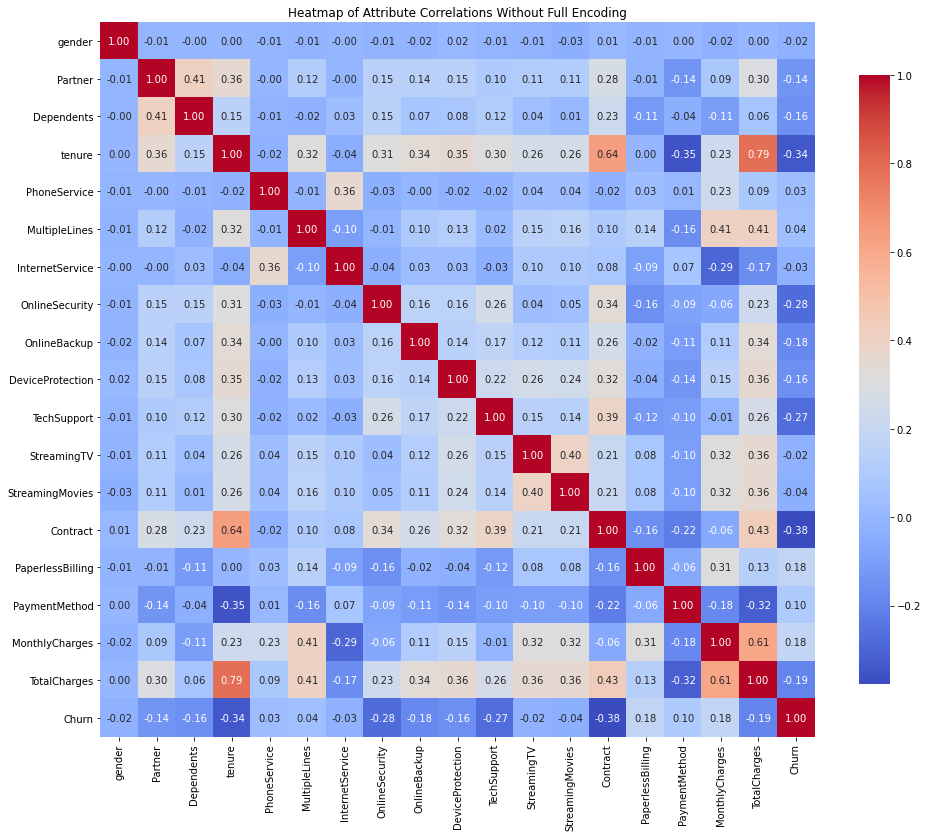

In [35]:
#Generating the heatmap to identify the correlated variables

label_encoded = train.copy()
categorical_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
                       'PaperlessBilling', 'PaymentMethod', 'Churn']

# Use label encoding
for column in categorical_columns:
    label_encoded[column] = label_encoded[column].astype('category').cat.codes

# Compute the correlation matrix
correlation_matrix = label_encoded.corr()

plt.figure(figsize=(16, 14))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, 
            cbar_kws={"shrink": .8})

plt.title('Heatmap of Attribute Correlations Without Full Encoding')
plt.show()


## Experimental Design

### Research Questions

In [36]:
# Count the number of churned customers
churned_customers = train[train['Churn'] == 'Yes'].shape[0]

# Count the total number of customers
total_customers = train.shape[0]

# Calculate the churn rate
churn_rate = (churned_customers / total_customers) * 100

print("Overall churn rate: {:.2f}%".format(churn_rate))

Overall churn rate: 26.98%


In [37]:
#finding the relationship between the tenure of a customer and their likelihood of churn
#Grouping the data by tenure
tenure_groups = pd.cut(train['tenure'], bins=[0, 12, 24, 36, 48, 60, 72])
churn_by_tenure = train.groupby(tenure_groups)['Churn'].value_counts(normalize=True).unstack()
#Calculating the churn rate for each tenure group
churn_rate_by_tenure = churn_by_tenure['Yes']


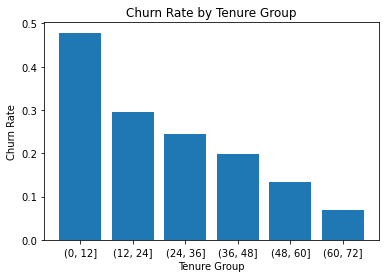

In [38]:
#Plotting the relationship
x = churn_rate_by_tenure.index.astype(str)
y = churn_rate_by_tenure.values

plt.bar(x, y)
plt.xlabel('Tenure Group')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Tenure Group')
plt.show()


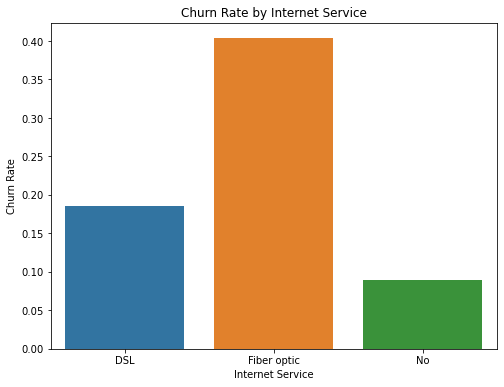

In [39]:
# Group the data by InternetService and calculate churn rate
churn_by_internet_service = train.groupby('InternetService')['Churn'].value_counts(normalize=True).unstack()
churn_by_internet_service = churn_by_internet_service.loc[:, 'Yes']

# Plotting the churn rates for each internet service category
plt.figure(figsize=(8, 6))
sns.barplot(x=churn_by_internet_service.index, y=churn_by_internet_service.values)
plt.xlabel('Internet Service')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Internet Service')
plt.show()


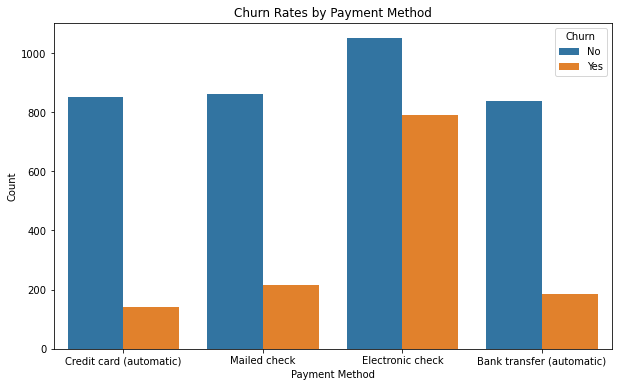

In [40]:
plt.figure(figsize=(10, 6))
sns.countplot(x='PaymentMethod', hue='Churn', data=train)
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.title('Churn Rates by Payment Method')
plt.show()

In [41]:
# Create the contingency table
contingency_table = [[0.831924, 0.666886], [0.168076, 0.333114]]

# Perform the chi-square test
chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)

# Compare the p-value with the significance level
if p_value < 0.05:
    print("There is a significant relationship between the customer's internet service provider and their likelihood of churn.")
else:
    print("There is no significant relationship between the customer's internet service provider and their likelihood of churn.")


There is no significant relationship between the customer's internet service provider and their likelihood of churn.


## Feature Engineering

<AxesSubplot:>

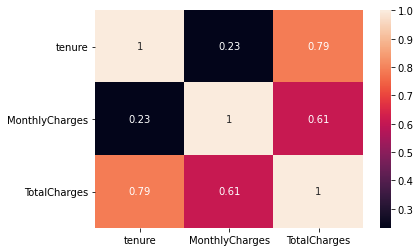

In [42]:
sns.heatmap(train.corr(),annot=True)

## Feature Encoding

In [43]:
#Encoding the target column
# Perform label encoding on 'Churn' column
label_encoder = LabelEncoder()
train['Churn'] = label_encoder.fit_transform(train['Churn'])

In [44]:
# Dividing numerical and categorical columns
numerical_columns = train.select_dtypes(include=['int64', 'float64','int32']).columns
categorical_columns = train.select_dtypes(include=['object']).columns

# Subset of the numerical and categorical columns
train_num = train[numerical_columns]
train_cat = train[categorical_columns]
# Convert boolean columns to strings
train_cat = train_cat.astype(str)
train_num.shape,train_cat.shape

((4930, 4), (4930, 16))

In [45]:
#Implementing OneHot Encoding
encoder = OneHotEncoder(sparse=False,drop='first',handle_unknown='error').set_output(transform='pandas')
encoder.fit(train_cat)
encoded_data = encoder.transform(train_cat)

encoded_data

,gender_Male,SeniorCitizen_Yes,SeniorCitizen_nan,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
4097,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1688,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
6215,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5828,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5586,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5668,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
6683,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2688,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2656,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [46]:
encoded_data.shape

(4930, 28)

In [47]:
encoded_data.columns

Index(['gender_Male', 'SeniorCitizen_Yes', 'SeniorCitizen_nan', 'Partner_Yes',
       'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No internet service',
       'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [48]:
encoded_train = pd.concat([train_num, encoded_data], axis=1)
encoded_train

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,SeniorCitizen_Yes,SeniorCitizen_nan,Partner_Yes,Dependents_Yes,PhoneService_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
4097,64.0,65.504322,6171.200000,0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1688,40.0,20.150000,804.850000,0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
6215,6.0,65.504322,560.600000,1,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5828,72.0,24.450000,1709.100000,0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5586,27.0,19.150000,501.350000,0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5668,39.0,101.250000,2280.414548,0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
6683,43.0,44.150000,1931.300000,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2688,5.0,78.750000,412.100000,1,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2656,39.0,59.300000,2209.150000,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


## Handling Data Imbalance


In [49]:
# Splitting the dataset into features (X) and target variable (y)
X = encoded_train.drop('Churn', axis=1)
y = encoded_train['Churn']

In [50]:
encoded_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
gender_Male,4930.0,0.529006,0.499209,0.0,0.0,1.0,1.0,1.0
SeniorCitizen_Yes,4930.0,0.153347,0.360358,0.0,0.0,0.0,0.0,1.0
SeniorCitizen_nan,4930.0,0.046450,0.210480,0.0,0.0,0.0,0.0,1.0
Partner_Yes,4930.0,0.462272,0.498625,0.0,0.0,0.0,1.0,1.0
Dependents_Yes,4930.0,0.281744,0.449895,0.0,0.0,0.0,1.0,1.0
PhoneService_Yes,4930.0,0.910548,0.285424,0.0,1.0,1.0,1.0,1.0
MultipleLines_No phone service,4930.0,0.088235,0.283666,0.0,0.0,0.0,0.0,1.0
MultipleLines_Yes,4930.0,0.406897,0.491305,0.0,0.0,0.0,1.0,1.0
InternetService_Fiber optic,4930.0,0.472819,0.499311,0.0,0.0,0.0,1.0,1.0
InternetService_No,4930.0,0.197972,0.398511,0.0,0.0,0.0,0.0,1.0


In [51]:
#Implementing SMOTE to help balance our data evenly in accordance to our class variable i.e Churn
smote = SMOTE(sampling_strategy='minority')
X_resampled, y_resampled= smote.fit_resample(X, y)
#Showcasing a equal count for each target value
y_resampled.value_counts()

0    3600
1    3600
Name: Churn, dtype: int64

In [53]:
print(X_resampled.shape)
print(y_resampled.shape)


(7200, 31)
(7200,)


## Data Splitting

In [54]:
# Split the data into training and evaluation sets (80-20 split ratio)
X_train, X_eval, y_train, y_eval = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42,stratify=y_resampled)


In [55]:
X_train.shape,X_eval.shape,y_train.shape,y_eval.shape

((5760, 31), (1440, 31), (5760,), (1440,))

### Data Scaling

In [56]:
#Cloning the standardscaler class
scaler =StandardScaler().set_output(transform="pandas")
# Columns to be scaled
columns_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']
#Fitting and transforming the selected columns in the training data set
X_train_scaled = X_train.copy()
X_train_scaled[columns_to_scale]=scaler.fit_transform(X_train[columns_to_scale])

#Transforming the selected columns  in the evaluation dataset
X_eval_scaled=X_eval.copy() 
X_eval_scaled[columns_to_scale] = scaler.transform(X_eval[columns_to_scale])

In [57]:
#Checking on the scaled training set
X_train_scaled.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Yes,SeniorCitizen_nan,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
908,0.259274,-1.386258,-0.537649,1.000000,0.000000,1.0,1.0,1.0,0.0,1.0,...,0.0,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0
7082,-0.142158,0.874481,0.022329,1.000000,0.218197,0.0,0.0,0.0,1.0,0.0,...,0.0,0.781803,0.0,0.781803,0.000000,0.000000,1.0,0.0,1.0,0.0
1586,-0.213231,0.477011,-0.125038,0.000000,0.000000,0.0,1.0,1.0,1.0,0.0,...,0.0,0.000000,0.0,0.000000,1.000000,0.000000,0.0,1.0,0.0,0.0
5542,0.702598,1.299194,1.633925,0.528214,0.528214,0.0,0.0,0.0,1.0,0.0,...,0.0,1.000000,0.0,1.000000,0.528214,0.471786,1.0,0.0,1.0,0.0
1203,0.903599,1.268312,1.400823,1.000000,0.000000,0.0,0.0,0.0,1.0,0.0,...,0.0,1.000000,0.0,1.000000,0.000000,0.000000,1.0,0.0,0.0,0.0


In [58]:
#To check on the scaled evaluation on the predictor set
X_eval_scaled.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Yes,SeniorCitizen_nan,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
4181,-0.470961,-1.739356,-0.825298,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2761,0.517004,-1.757463,-0.613955,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4246,-1.201196,-1.569145,0.097099,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1571,-0.256186,0.381041,-0.157254,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
619,1.719743,1.118019,2.172730,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


### Data Modelling

In [59]:
# Defining a list of models that will be evaluated
models = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('Support Vector Machine', SVC(random_state=42)),
    ('Gaussian Naive Bayes', GaussianNB()),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('LightGBM', LGBMClassifier(random_state=42)),
]

results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'])

for model_name, model in models:
    # Fitting the models to the training dataset
    model.fit(X_train_scaled, y_train)

    # Make predictions using the evaluation dataset
    y_pred = model.predict(X_eval_scaled)

    accuracy = accuracy_score(y_eval, y_pred)
    precision = precision_score(y_eval, y_pred)
    recall = recall_score(y_eval, y_pred)
    f1 = f1_score(y_eval, y_pred)
    auc_roc = roc_auc_score(y_eval, y_pred)

    results_df = results_df.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC-ROC': auc_roc
    }, ignore_index=True)



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2880, number of negative: 2880
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5051
[LightGBM] [Info] Number of data points in the train set: 5760, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [60]:
#Evaluation scores dataframe
results_df

,Model,Accuracy,Precision,Recall,F1 Score,AUC-ROC
0,Logistic Regression,0.763194,0.757823,0.773611,0.765636,0.763194
1,Random Forest,0.850000,0.876119,0.815278,0.844604,0.850000
2,Gradient Boosting,0.847917,0.854314,0.838889,0.846531,0.847917
3,Support Vector Machine,0.821528,0.825598,0.815278,0.820405,0.821528
4,Gaussian Naive Bayes,0.742361,0.702202,0.841667,0.765635,0.742361
5,K-Nearest Neighbors,0.779167,0.725336,0.898611,0.802730,0.779167
6,Decision Tree,0.790972,0.792190,0.788889,0.790536,0.790972
7,XGBoost,0.852083,0.864748,0.834722,0.849470,0.852083
8,LightGBM,0.850694,0.867540,0.827778,0.847193,0.850694


## Hyperparameter Tuning


#### Random Forest Model

In [61]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [62]:
# Defining the parameter grid for Random Forest m
param_grid_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 50],
    'min_samples_split': [2, 5,10, 12],
    'min_samples_leaf': [1, 2,4, 8]
}


In [ ]:
# Defining a random forest model
rf = RandomForestClassifier(random_state=42)
#Perfoming a grid search using cross validation
grid_search_rf = GridSearchCV(rf, param_grid_rf, scoring='f1', cv=5)
grid_search_rf.fit(X_train_scaled, y_train)

In [78]:
# Getting the best parameters
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

In [79]:
#best parameters for the random forest model
print(f"The best hyperparameters for the Random Forest model are:\n{best_params_rf}")

The best hyperparameters for the Random Forest model are:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


#### LightGBM model

In [80]:
param_grid_lgbm = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.1, 0.01, 0.001]
}


In [81]:
lgbm = LGBMClassifier(random_state=42)

# Performing Grid Search Cross Validation
grid_search_lgbm = GridSearchCV(lgbm, param_grid_lgbm, scoring='f1', cv=5)
grid_search_lgbm.fit(X_train_scaled, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2304, number of negative: 2304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4655
[LightGBM] [Info] Number of data points in the train set: 4608, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [5, 10, 15],
                         'n_estimators': [100, 200, 300]},
             scoring='f1')

In [82]:
best_params_lgbm = grid_search_lgbm.best_params_
best_score_lgbm = grid_search_lgbm.best_score_
#Printing the best hyperparameters
print(f"The best hyperparameters for the light gbm model are:\n{best_params_lgbm}")

#### Hyperparameter Tuning on the Catboost Model

In [84]:
# Define the parameter grid for Grid Search
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

In [85]:
# Define the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)


In [86]:
# Performing Grid Search with cross-validation
grid_search = GridSearchCV(gb_model, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='f1')

In [87]:
# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_gb = grid_search.best_estimator_ 

In [88]:
print(f"The best hyperparameters for the Gradient boosting classifier are: \n{best_params}")

The best hyperparameters for the Gradient boosting classifier are: 
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


  ### Perfomance Comparison after Hyperparameter Tuning

In [89]:
results_tuned_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'])

rf_model_tuned = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, min_samples_leaf=1, random_state=42)
lgbm_model_tuned = LGBMClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, random_state=42)
gb_model_tuned = GradientBoostingClassifier(random_state=42,learning_rate=0.1,max_depth=3,n_estimators=100)
# Fitting the tuned models to the training data
rf_model_tuned.fit(X_train_scaled, y_train)
lgbm_model_tuned.fit(X_train_scaled, y_train)
gb_model_tuned.fit(X_train_scaled,y_train)


# predictions on the evaluation data
y_pred_rf = rf_model_tuned.predict(X_eval_scaled)
y_pred_lgbm = lgbm_model_tuned.predict(X_eval_scaled)
y_pred_gb =gb_model_tuned.predict(X_eval_scaled)

# Calculating the evaluation scores of different models
accuracy_rf = accuracy_score(y_eval, y_pred_rf)
precision_rf = precision_score(y_eval, y_pred_rf)
recall_rf = recall_score(y_eval, y_pred_rf)
f1_rf = f1_score(y_eval, y_pred_rf)
auc_roc_rf = roc_auc_score(y_eval, y_pred_rf)

accuracy_lgbm = accuracy_score(y_eval, y_pred_lgbm)
precision_lgbm = precision_score(y_eval, y_pred_lgbm)
recall_lgbm = recall_score(y_eval, y_pred_lgbm)
f1_lgbm = f1_score(y_eval, y_pred_lgbm)
auc_roc_lgbm = roc_auc_score(y_eval, y_pred_lgbm)

accuracy_gb = accuracy_score(y_eval, y_pred_gb)
precision_gb = precision_score(y_eval, y_pred_gb)
recall_gb = recall_score(y_eval, y_pred_gb)
f1_gb = f1_score(y_eval, y_pred_gb)
auc_roc_gb = roc_auc_score(y_eval, y_pred_gb)

# Compiling said results into a dataframe
results_tuned_df = results_tuned_df.append({'Model': 'Random Forest (Tuned)',
                                'Accuracy': accuracy_rf,
                                'Precision': precision_rf,
                                'Recall': recall_rf,
                                'F1 Score': f1_rf,
                                'AUC-ROC': auc_roc_rf}, ignore_index=True)

results_tuned_df = results_tuned_df.append({'Model': 'LightGBM (Tuned)',
                                'Accuracy': accuracy_lgbm,
                                'Precision': precision_lgbm,
                                'Recall': recall_lgbm,
                                'F1 Score': f1_lgbm,
                                'AUC-ROC': auc_roc_lgbm}, ignore_index=True)

results_tuned_df = results_tuned_df.append({'Model': 'Gradient Boosting (Tuned)',
                                'Accuracy': accuracy_gb,
                                'Precision': precision_gb,
                                'Recall': recall_gb,
                                'F1 Score': f1_gb,
                                'AUC-ROC': auc_roc_gb}, ignore_index=True)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2880, number of negative: 2880
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4882
[LightGBM] [Info] Number of data points in the train set: 5760, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

In [90]:
#Evaluation scores for the tuned models after hyper parameter tuning
results_tuned_df

,Model,Accuracy,Precision,Recall,F1 Score,AUC-ROC
0,Random Forest (Tuned),0.853472,0.858956,0.845833,0.852344,0.853472
1,LightGBM (Tuned),0.848611,0.865889,0.825000,0.844950,0.848611
2,Gradient Boosting (Tuned),0.845833,0.856734,0.830556,0.843441,0.845833


In [91]:
#Evaluation scores for the untuned models without hyper parameter tuning
results_df

,Model,Accuracy,Precision,Recall,F1 Score,AUC-ROC
0,Logistic Regression,0.760417,0.755102,0.770833,0.762887,0.760417
1,Random Forest,0.853472,0.873715,0.826389,0.849393,0.853472
2,Gradient Boosting,0.845833,0.856734,0.830556,0.843441,0.845833
3,Support Vector Machine,0.820833,0.827195,0.811111,0.819074,0.820833
4,Gaussian Naive Bayes,0.756944,0.750678,0.769444,0.759945,0.756944
5,K-Nearest Neighbors,0.772917,0.720045,0.893056,0.797272,0.772917
6,Decision Tree,0.798611,0.807143,0.784722,0.795775,0.798611
7,XGBoost,0.840278,0.856105,0.818056,0.836648,0.840278
8,LightGBM,0.850694,0.869693,0.825000,0.846757,0.850694


### Feature Importance


In [92]:
# Get feature importances from the Random Forest model to indicate the most relevant datapoints
feature_importances = rf_model_tuned.feature_importances_

# Create a dataframe to store the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df


,Feature,Importance
22,PaymentMethod_Electronic check,0.116032
0,tenure,0.112994
19,Contract_Two year,0.085817
2,TotalCharges,0.075412
10,InternetService_Fiber optic,0.072662
20,PaperlessBilling_Yes,0.060882
1,MonthlyCharges,0.059796
12,OnlineSecurity_Yes,0.058153
15,TechSupport_Yes,0.057634
18,Contract_One year,0.057149


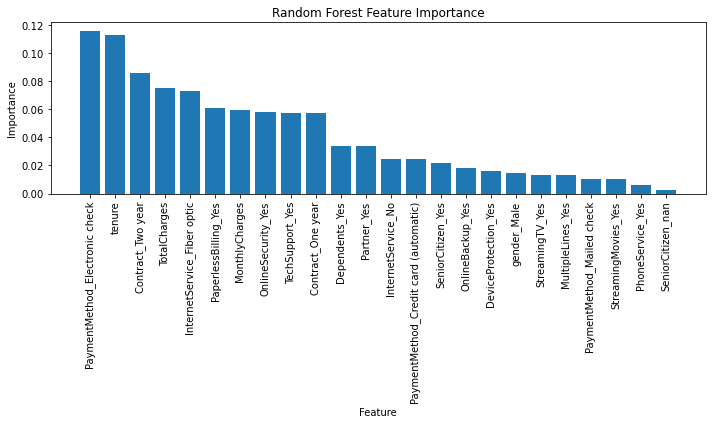

In [93]:
# Plotting the feature importances with respect to their importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()
